<a href="https://colab.research.google.com/github/palberth/Modelos_y_Metodos_de_Sistemas_Inteligentes/blob/main/Sistema_Inferencia_Difuso_Calidad_Aire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌫️ Sistema de Inferencia Difuso para Clasificación de Calidad del Aire

## 🎯 Objetivo
Diseñar un sistema de inferencia difuso que clasifique la calidad del aire (Air Quality) utilizando tres variables clave:

- **PM2.5 (µg/m³)**
- **NO2 (ppb)**
- **Proximidad a zonas industriales (km)**

La salida será una recomendación lingüística sobre la **Calidad del Aire**, con valores: **Buena**, **Moderada**, **Mala**, o **Peligrosa**.


## 1. Carga de Librerías

In [2]:
!pip install scikit-fuzzy matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## 2. Definición de Variables del Universo y Funciones de Pertenencia

In [4]:
# Variables de entrada
pm25 = ctrl.Antecedent(np.arange(0, 301, 1), 'PM2_5')
no2 = ctrl.Antecedent(np.arange(0, 71, 1), 'NO2')
proximidad = ctrl.Antecedent(np.arange(0, 26, 1), 'Proximidad')

# Variable de salida
calidad_aire = ctrl.Consequent(np.arange(0, 101, 1), 'Calidad_Aire')

# Funciones de pertenencia - PM2.5
pm25['bajo'] = fuzz.trimf(pm25.universe, [0, 0, 15])
pm25['medio'] = fuzz.trimf(pm25.universe, [10, 25, 40])
pm25['alto'] = fuzz.trimf(pm25.universe, [30, 150, 300])

# Funciones de pertenencia - NO2
no2['bajo'] = fuzz.trimf(no2.universe, [0, 0, 20])
no2['medio'] = fuzz.trimf(no2.universe, [15, 30, 45])
no2['alto'] = fuzz.trimf(no2.universe, [40, 55, 70])

# Funciones de pertenencia - Proximidad
proximidad['cercano'] = fuzz.trimf(proximidad.universe, [0, 0, 5])
proximidad['medio'] = fuzz.trimf(proximidad.universe, [4, 8, 12])
proximidad['lejano'] = fuzz.trimf(proximidad.universe, [10, 20, 25])

# Funciones de pertenencia - Calidad del Aire
calidad_aire['buena'] = fuzz.trimf(calidad_aire.universe, [0, 0, 30])
calidad_aire['moderada'] = fuzz.trimf(calidad_aire.universe, [20, 40, 60])
calidad_aire['mala'] = fuzz.trimf(calidad_aire.universe, [50, 70, 85])
calidad_aire['peligrosa'] = fuzz.trimf(calidad_aire.universe, [80, 100, 100])


## 3. Visualización de Funciones de Pertenencia

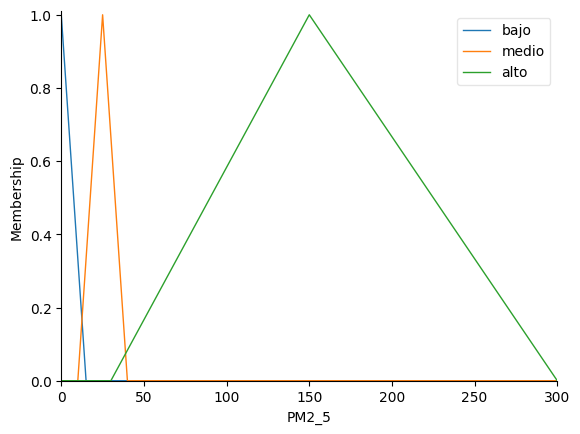

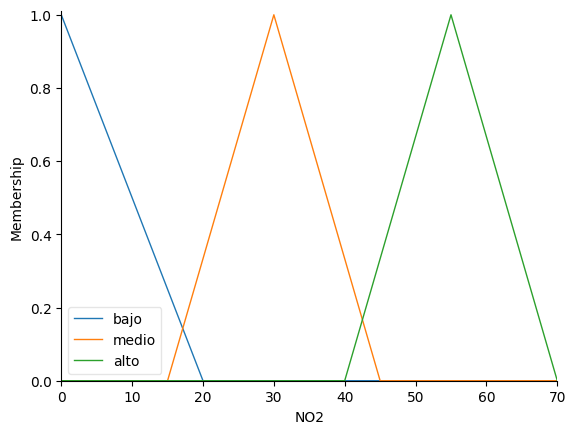

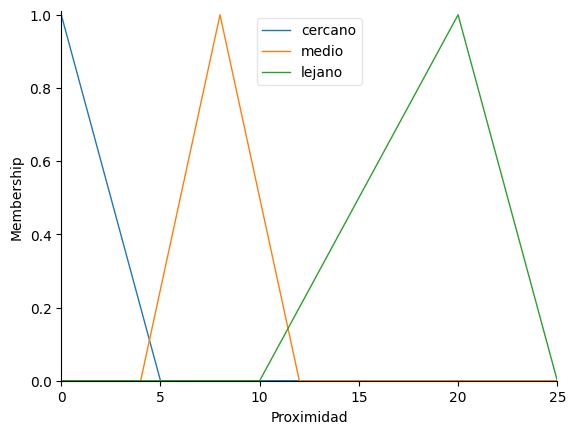

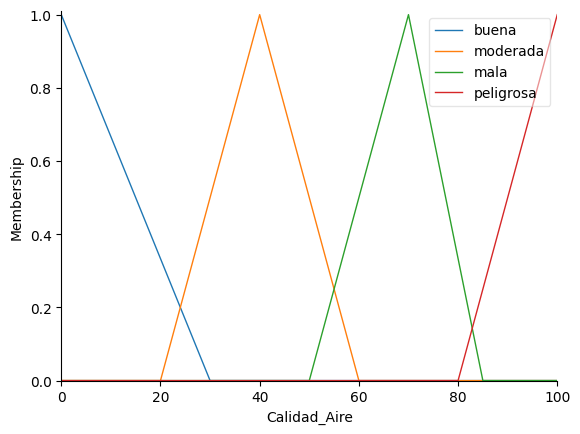

In [5]:
pm25.view()
no2.view()
proximidad.view()
calidad_aire.view()


## 4. Definición de Reglas Difusas

In [6]:
reglas = [
    ctrl.Rule(pm25['bajo'] & no2['bajo'] & proximidad['lejano'], calidad_aire['buena']),
    ctrl.Rule(pm25['bajo'] & no2['medio'] & proximidad['medio'], calidad_aire['moderada']),
    ctrl.Rule(pm25['medio'] & no2['medio'] & proximidad['cercano'], calidad_aire['mala']),
    ctrl.Rule(pm25['alto'] & no2['alto'] & proximidad['cercano'], calidad_aire['peligrosa']),
    ctrl.Rule(pm25['medio'] & no2['alto'] & proximidad['medio'], calidad_aire['mala']),
    ctrl.Rule(pm25['alto'] & no2['medio'] & proximidad['lejano'], calidad_aire['moderada']),
    ctrl.Rule(pm25['alto'] & no2['alto'] & proximidad['lejano'], calidad_aire['mala']),
    ctrl.Rule(pm25['medio'] & no2['bajo'] & proximidad['medio'], calidad_aire['moderada']),
    ctrl.Rule(pm25['bajo'] & no2['alto'] & proximidad['cercano'], calidad_aire['mala'])
]

sistema_calidad_aire = ctrl.ControlSystem(reglas)
simulador = ctrl.ControlSystemSimulation(sistema_calidad_aire)


## 5. Simulación con Entradas Específicas

Calidad del aire estimada: 91.83


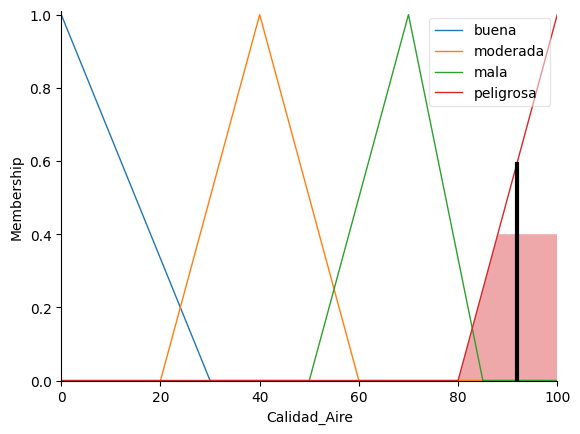

In [7]:
simulador.input['PM2_5'] = 120
simulador.input['NO2'] = 60
simulador.input['Proximidad'] = 3

simulador.compute()
print(f"Calidad del aire estimada: {simulador.output['Calidad_Aire']:.2f}")
calidad_aire.view(sim=simulador)


## 6. Visualización de Superficie de Control

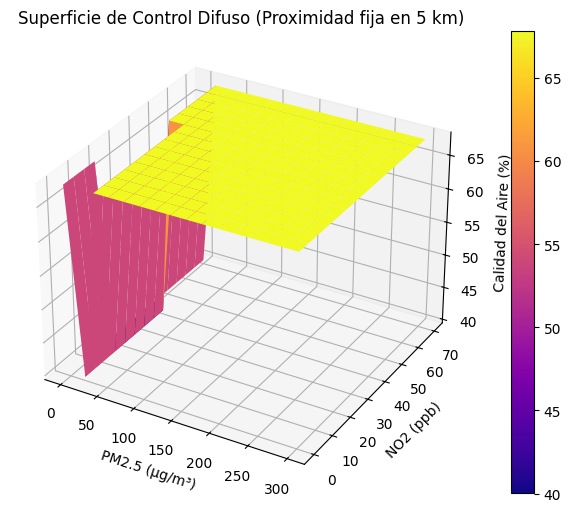

In [10]:
x_pm25 = np.arange(0, 301, 20)
y_no2 = np.arange(0, 71, 5)
x, y = np.meshgrid(x_pm25, y_no2)
z = np.zeros_like(x, dtype=float)

for i in range(len(x_pm25)):
    for j in range(len(y_no2)):
        simulador.input['PM2_5'] = x[j, i]
        simulador.input['NO2'] = y[j, i]
        simulador.input['Proximidad'] = 5
        try:
            simulador.compute()
            z[j, i] = simulador.output['Calidad_Aire']
        except:
            z[j, i] = np.nan

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='plasma')
ax.set_xlabel('PM2.5 (µg/m³)')
ax.set_ylabel('NO2 (ppb)')
ax.set_zlabel('Calidad del Aire (%)')
plt.title('Superficie de Control Difuso (Proximidad fija en 5 km)')
plt.colorbar(surf)
plt.show()


## 7. Conclusión

Este sistema demuestra cómo un modelo difuso puede incorporar múltiples factores ambientales para clasificar la calidad del aire. La inferencia es intuitiva y se adapta bien a los rangos graduales e inciertos de la contaminación urbana.